<br></br>
<h1 style = "font-weight:bold;"> Higgs-Suche mit Python </h1>

Nachdem ihr in den $\text{H}\to\text{ZZ}\to4\ell$ Prozess eingeführt wurdet, werden wir jetzt versuchen das Higgs-Boson in diesem Zerfallskanal zu entdecken. Dafür benutzen wir **Python** und die schon vorbereiteten, öffentlichen Daten von **CMS**, die 2012 aufgenommen wurden. Nachdem wir diese Daten eingelesen haben, werden wir die für uns interessanten Objekte auswählen (z.B. hier die Leptonen), auf Basis dieser die Events selektieren, die unserem Signal ähneln und damit am Ende den Signalprozess vermessen.
<a name="überblick"></a>
## [Überblick]()
* [Der Datensatz](#datensatz)
* [Definition der Objekte](#objekte)
* [Selektion der Events](#selektion)
* [Vergleich mit Simulation](#simulation)
* [Extraktion des Signals](#extraktion)

___
<a name="datensatz"></a>
## [Der Datensatz](#überblick)
Zunächst importieren wir verschiedene Module, welche wir zum Bewältigen dieser Aufgabe benötigen. Diese enthalten nützliche _Funktionen_ (siehe Python-Übung), welchen wir lediglich ein paar Parameter übergeben müssen, um eine bestimmte Aufgabe zu lösen. Um die Funktionen aus den Bibliotheken zu laden, führe einfach die nächsten Zeilen aus.

In [1]:
import awkward as ak
import h5py
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import os
import yaml
from helpers import load_simulation, stack, get_Z_candidates, plot_m4l, plot_m4l_bkg, load_data, get_e_mu_pT_cut, perform_all_cuts

mplhep.style.use("CMS")

Mit den geladenen Funktionen können wir nun die Daten einlesen. Wie ihr in der Einführung gelernt habt, nimmt das **CMS** Experiment unvorstellbar große Datenmengen auf, daher können wir natürlich nicht in alle Events reinschauen um zu gucken, ob dort ein Higgs produziert wurde. Stattdessen wurde eine Vorauswahl an Daten getätigt, um die Dateigröße zu reduzieren. Da wir an dem $\text{H}\to\text{ZZ}\to4\ell$ Prozess interessiert sind, ist das Hauptkriterium, auf Basis dessen wir diese Vorauswahl tätigen, dass in dem Event mindestens 4 Leptonen (also Elektronen oder Myonen) enthalten sein müssen.
Die entsprechenden Dateien sind im Ordner `data_files` gespeichert. Mit dem Folgenden Befehl werden alle Dateien eingelesen und dem *dict* `datasets` hinzugefügt.  

In [2]:
data = load_data("data_files")

Wenn wir uns dieses *dict* jetzt genauer anschauen, sehen wir, dass in diesem die für uns relevanten Objekte, nämlich die Leptonen gespeichert sind, mit ihren für uns relevanten kinemantischen Eigenschaften

In [3]:
print(data.keys())
print(data["muons"])

dict_keys(['muons', 'electrons'])
[[{pt: 5.03, eta: -0.0538, phi: -2.68, charge: 1, mass: 0.106}, ...], ...]


<a name="objekte"></a>
## [Definition der Objekte](#überblick)

In `datasets` sind jetzt all unsere events enhalten. In allen Events wiederum gibt es viele verschieden Objekte, die man Auslesen kann, zum Beispiel die *jets* die es in einem event gibt, oder eben die Leptonen. Da für unsere Analyse die Leptonen so wichtig sind, wollen wir das diese besonders gut reconstruiert sind. Um das zu garantieren werden wir im Folgenden nur noch Leptonen in Betracht ziehen, die die Folgenden Bedingungen erfüllen:

- Der transversale Impuls $p_\text{T}$ von Myonen bzw. Elektronen ist größer als $5\,\text{GeV}$ bzw.  $7\,\text{GeV}$
- Die Leptonen sind innerhalb des Spurdetektors, also $|\eta|<2.4$


Starten wir mit den Myonen. Lassen wir uns dazu zunächst das $p_\text{T}$ (in GeV) aller Myonen in den ersten 5 events ausgeben.

In [4]:
muons = data["muons"]
print("Myon pT der ersten 5 events:", muons["pt"][:5])

Myon pT der ersten 5 events: [[5.03, 3.78], [10.2, 14.4], [26.5, 9.88], [], [7.46, 5.4]]


Wie wir sehen gibt es zum Beispiel im ersten Event 2 Myonen, eins mit $p_\text{T}=5.03\,\text{GeV}$, das andere mit $p_\text{T}=3.78\,\text{GeV}$. Versucht euch nun das $\eta$ ausgeben zu lassen.

> **_HINWEIS:_** Wie ihr oben gesehen habt, hat die variable $\eta$ der Myonen den **key** `"eta"`

In [5]:
# TODO: Gebt eta der Myonen aus!
print("Myon eta der ersten 5 events:", muons["eta"][:5])

Myon eta der ersten 5 events: [[-0.0538, -0.033], [-0.287, -0.271], [1.83, ...], [], [-0.915, -0.906]]


Jetzt können wir die Bedingungen an die Objekte, die wir oben (#objekte) definiert haben, implementieren. Dazu nutzen wir die "Relationalen Operatoren"  `>`  und  `<`, die ihr in dem python intro kennen gelernt habt:

In [6]:
passes_pt = (muons["pt"] > 5)
passes_eta = abs(muons["eta"]) < 2.4

Von jetzt an, wollen wir uns nur noch die Myonen angucken, die diese Anforderungen erfüllen. Da beide Anforderungen erfüllt sein sollen, nutzen wir den "und" operator `&`:

In [7]:
muons = muons[passes_pt & passes_eta]

Wenn wir uns nun das $p_\text{T}$ all dieser Myonen in den ersten 5 Events ausgeben lassen, sehen wir, dass alle Werte jetzt über 5 sind:

In [8]:
print(muons["pt"][:5])

[[5.03], [10.2, 14.4], [26.5, 9.88], [], [7.46, 5.4]]


Nun müssen nicht nur die Myonen, sondern auch die Elektronen $p_\text{T}$ und $\eta$ Anforderungen erfüllen (siehe oben). Versucht im Folgenden diese zu implementieren.

In [9]:
#TODO Implementiert hier die Elektron Bedingungen equivalent zu dem, was wir oben für die Myonen gemacht haben

electrons = data["electrons"]
passes_pt = electrons["pt"] > 7
passes_eta = abs(electrons["eta"]) < 2.5
electrons = electrons[passes_pt & passes_eta]

Um sicherzugehen, dass es funktioniert hat, gebt euch nun das $p_\text{T}$ der Elektronen in den ersten 5 events aus.

In [10]:
print(electrons["pt"][:5])

[[28.6, 21.8], [16.6, 49.6], [58.6, 96.9], [34.1, 35.9], [19.7, 22.6]]


Mit unseren Objekten erfolgreich definiert, können wir nun zu der tatsächlichen Auswahl der Signal-Events kommen

<a name="selektion"></a>
## [Selektion der Events](#überblick)

In diesem Abschnitt werden wir die Eigenschaften (z.B die Ladung) der Leptonen nutzen um nur die Event zu selektieren, die mit unseren Erwartungen an den Signal-Prozess übereinstimmen. Um nach jeder Selection (nach jedem "cut") einen Überblick zu bekommen, wie sich diese auf unsere Daten ausgewirkt hat, können wir uns zwischen jedem cut die Verteilung der invariante Masse aller leptonen $m_{4\ell}$ anzeigen lassen. Dies geht mit der Funktion `plot_m4l()`. Diese braucht als Argumente die Elektronen und Myonen:

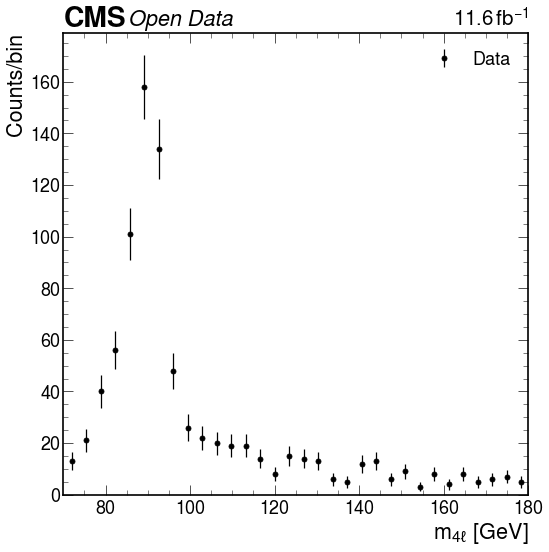

In [11]:
plot_m4l(electrons, muons)

### Anzahl der Elektronen und Myonen
Als ersten Selektionsschritt können wir nun für alle Events fordern, dass es eine gerade Anzahl an Elektronen und Myonen geben muss.
Warum fordern wir dies? Schaut euch nochmal den Feynmann-graphen für $\text{H}\to\text{ZZ}\to4\ell$ an. Warum gibt muss es eine gerade Anzahl an Myonen und Elektronen im Endzustand geben?

Unter der Voraussetzung, dass es eine gerade Anzahl an Elektronen und Myonen gibt, gibt es für uns 3 verschiedene Fälle zu betrachten. Der erste Fall wäre, dass es 4 Elektronen gibt und keine Myonen. Welche weiteren Zwei Fälle gibt es?

In **Python** kann man Forderungen an die Anzahl bestimmter Objekte mit der Funktion `ak.num()` machen (num ist hier kurz für "number", also Anzahl). Im Folgenden ist der Fall 4 Elektronen und 0 Myonen bespielhaft implementiert. Ergänzt diesen Fall um die beiden anderen Fälle, die ihr euch überlegt habt.

In [12]:
fall_1 = (ak.num(muons) == 0) & (ak.num(electrons) == 4)
# TODO: Implementiert hier Fall 2 und Fall 3
fall_2 = (ak.num(muons) == 4) & (ak.num(electrons) == 0)
fall_3 = (ak.num(muons) == 2) & (ak.num(electrons) == 2)

Nun verlangen wir von allen events, dass sie einen dieser Fälle erfüllen, dafür benutzen wir die "oder" funktion in python`|`:

In [13]:
passes_flav = fall_1 | fall_2 | fall_3
electrons = electrons[passes_flav]
muons = muons[passes_flav]

Jetzt können wir uns erneut die Verteilung der $m_{4\ell}$ ansehen:

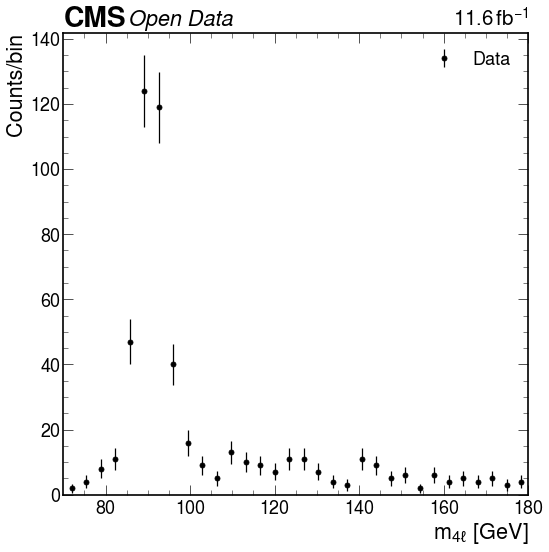

In [14]:
plot_m4l(electrons, muons)

### Ladung der Leptonen

Ladung ist eine Erhaltungsgröße. Da die $\text{Z}$ -Bosonen keine elektrische Ladung haben, muss daher auch die Summer der Ladungen der Zerfallsprodukte 0 sein:
$$ Q_\text{vorher} = Q_\text{nachher} $$
$$ Q_\text{Z} =0= Q_{\ell 1} + Q_{\ell 2} $$
Dies gilt für beide Z Bosonen, in die das Higgs zerfällt. Das heißt, dass die Summe der Ladungen von allen Myonen in jedem Event 0 sein muss und, dass die Summe der Ladungen aller Elektronen in jedem Event 0 sein muss. Für die Elektronen ist das wie folgt implementiert:

In [15]:
sum_charge_electron = ak.sum(electrons["charge"], axis = 1)
has_0Q_electrons = (sum_charge_electron == 0)

Hierbei berechnet die Funktion `ak.sum()` die summe der Ladung der Elektronen (`electrons["charge"]`), wobei `axis=1` bewirkt, dass das für jedes Event einzeln gemacht wird und nicht die Ladung über alle events summiert wird. Dann fordern wir, dass diese Summe genau gleich 0 ist (`== 0`). Macht im Folgenden Block das Gleiche für die Myonen!

In [16]:
# TODO: Implementiert die Ladungsanforderung für die Myonen!
sum_charge_muon = ak.sum(muons["charge"], axis = 1)
has_0Q_muons = (sum_charge_muon == 0)

Diese Forderungen wenden wir jetzt auf alle events an, wobei immer **beides** gelten muss, Ladungssumme der Elektronen **und** (`&`) der Myonen ist 0:

In [17]:
passes_0Q = has_0Q_electrons & has_0Q_muons
electrons = electrons[passes_0Q]
muons = muons[passes_0Q]

Nachdem wir diese zweite Bedingung eingebaut haben, können wir uns wieder die Verteilung $m_{4\ell}$ anzeigen lassen. Macht das in diesem nächsten Block:

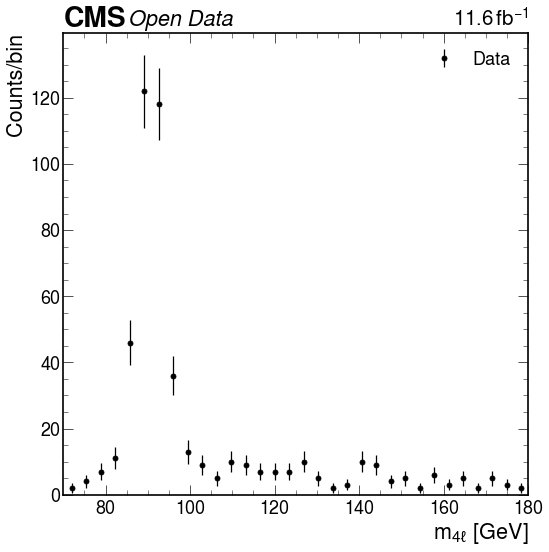

In [18]:
# TODO: Lasst euch die m_4l verteilung anzeigen!
plot_m4l(electrons, muons)

Jetzt könnt ihr womöglich schon einen kleinen Peak bei $125\,\text{GeV}$ sehen. Um diesen noch deutlicher sichtbar zu machen, wenden wir nun eine Bedingung an, die den Untergrund noch weiter reduzieren soll:

### Z Massen Fenster
Da die 4 Leptonen in unserem Endzustand aus 2 Z Bosonen entspringen, können wir uns jetzt die Leptonen angucken, die am ehsten "zusammen gehören", also aus dem gleichen Z kommen. Für diese sollte nämlich gelten, dass die invariante Masse ungefähr der Z Masse ($91\,\text{GeV}$) enspricht. Außerdem ergibt es Sinn zu fordern, dass die Leptonen in einem solchen Paar, nicht zu nah aneinander sind, damit wir sicher sein können, das beide tatsächlich aus dem ursprünglichen Prozess kommen und nicht eines erst später abgestrahlt wurde.

Etwas konkreter, konstruieren wir mit einem Algorithmus (implementiert als `get_Z_candidates()`) zwei lepton-paare, Paar 1 und Paar 2. Für die invariante Masse von Paar 1 soll gelten $40\,\text{GeV} < $`m_Z1`$<120\,\text{GeV}$, für Paar 2 soll gelten $12\,\text{GeV} < $`m_Z2`$<120\,\text{GeV}$. Für die Abstände der Leptonen von Paar 1 und Paar 2 soll gelten `dR1`$>0.02$.

Im folgenden Block ist eine Implementierung angefangen. Versucht diese zu vervollständigen!

In [19]:
### Z Fenster
mZ_1, mZ_2, dR1, dR2 = get_Z_candidates(muons, electrons)
passes_Z1 = (mZ_1 > 40) & (mZ_1 < 120)
passes_Z2 = (mZ_2 > 12) & (mZ_2 < 120)

### dR cut
passes_dRcut = (dR1 > 0.02) & (dR2 > 0.02)

# Beide zusammenführen
passes_Zcuts = passes_Z1 & passes_Z2 & passes_dRcut
electrons = electrons[passes_Zcuts]
muons = muons[passes_Zcuts]

Und nun könnt ihr euch $m_{4\ell}$ wieder anzeigen lassen:

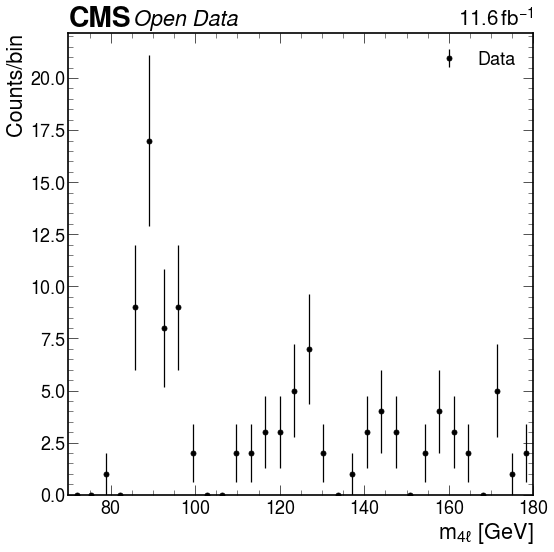

In [20]:
plot_m4l(electrons, muons)

Probiert mal die Fenstergröße um die Z-Masse, sowie den dR-cut zu verändern und guckt, wie es sich auf die $m_{4\ell}$-Verteilung auswirkt. 

### $p_\text{T}$ Bedingung im 2e2 $\mu$ Kanal

Im 2e2 $\mu$ kanal muss aus "technischen" Gründen (bei Interesse fragt gerne die Betreuer*innen) ein zusätzlicher $p_\text{T}$ cut gemacht werden. Dieser ist implementiert als `get_2e2mu_pT_cut()`:

In [21]:
passes_pt_2e2mu = get_e_mu_pT_cut(electrons, muons)
electrons = electrons[passes_pt_2e2mu]
muons = muons[passes_pt_2e2mu]

Diese letzte Anforderung sollte aber keinen großen Unterschied machen:

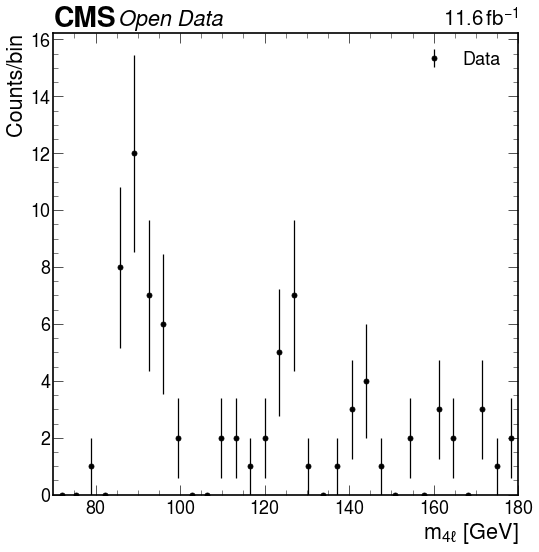

In [22]:
plot_m4l(electrons, muons)


<a name="Simulation"></a>
## [Vergleich mit Simulation](#überblick)

Nun, da wir alle relevanten Bedingungen an die Daten gestellt haben, können wir genau das Gleiche mit unserer SImulation machen. Dazu benutzen wir einen `for`-loop (siehe python-intro). Im ersten Schritt lesen wir alle Daten/Simulationen ein. Diese sind im Ordner `simulation_files` gespeichert. Die Name aller Dateien in diesem Ordnern können wir uns mit dem Befehl `os.listdir()` anzeigen lassen:

In [23]:
file_names = os.listdir("simulation_files")
print(file_names)

['SMHiggsToZZTo4L.h5', 'ZZTo2e2mu.h5', 'ZZTo4e.h5', 'ZZTo4mu.h5', 'Run2012B_DoubleElectron.h5', 'Run2012B_DoubleMuParked.h5', 'Run2012C_DoubleElectron.h5', 'Run2012C_DoubleMuParked.h5']


Jetzt können wir über all diese Dateien "loopen" und die entsprechenden Daten speichern. Dafür nutzen wir den Befehl `load_simulation()`

In [24]:
datasets = {}
for file_name in file_names:
    print("Working on:", file_name)
    datasets.update(load_simulation(file_name))
print("Finished!")

Working on: SMHiggsToZZTo4L.h5
Working on: ZZTo2e2mu.h5


Working on: ZZTo4e.h5
Working on: ZZTo4mu.h5
Working on: Run2012B_DoubleElectron.h5
Working on: Run2012B_DoubleMuParked.h5
Working on: Run2012C_DoubleElectron.h5
Working on: Run2012C_DoubleMuParked.h5
Finished!


In [25]:
masses = {}

for name, dataset in datasets.items():
    print(f"Processing dataset {name}")

    electrons = dataset["electrons"]
    muons = dataset["muons"]
    n_Events_before = len(muons)

    m4l = perform_all_cuts(electrons, muons)
    n_Events_after = len(m4l)

    print(f"   Events before processing: {n_Events_before}")
    print(f"   Events after processing: {n_Events_after}")
    
    masses.update({name: m4l})

Processing dataset SMHiggsToZZTo4L
   Events before processing: 39805
   Events after processing: 23185
Processing dataset ZZTo2e2mu
   Events before processing: 116010
   Events after processing: 51249
Processing dataset ZZTo4e
   Events before processing: 96104
   Events after processing: 62138
Processing dataset ZZTo4mu
   Events before processing: 178229
   Events after processing: 101660
Processing dataset Run2012B_DoubleElectron
   Events before processing: 162
   Events after processing: 43
Processing dataset Run2012B_DoubleMuParked
   Events before processing: 405
   Events after processing: 69
Processing dataset Run2012C_DoubleElectron
   Events before processing: 279
   Events after processing: 69
Processing dataset Run2012C_DoubleMuParked
   Events before processing: 662
   Events after processing: 122


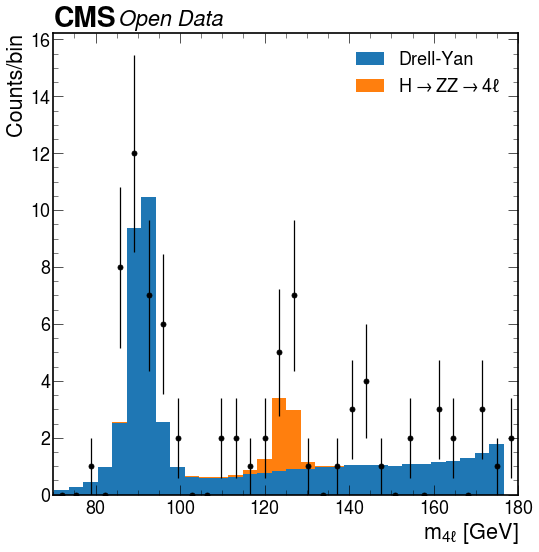

In [26]:
bin_start = 60
bin_stop = 180
number_of_bins = 36

bins_m4l = np.linspace(bin_start, bin_stop, number_of_bins)

plot_m4l_bkg(masses, blinded = False, bins=bins_m4l)